## Imports

In [1]:
import cv2
import numpy as np
from numpy import save
import math as m
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from numpy import moveaxis
from numpy import asarray
import torch
from scipy.stats import multivariate_normal
import torchvision
from torch.linalg import multi_dot
from HyperParameters import *
from Functions import *
from matplotlib import cm


## Read data

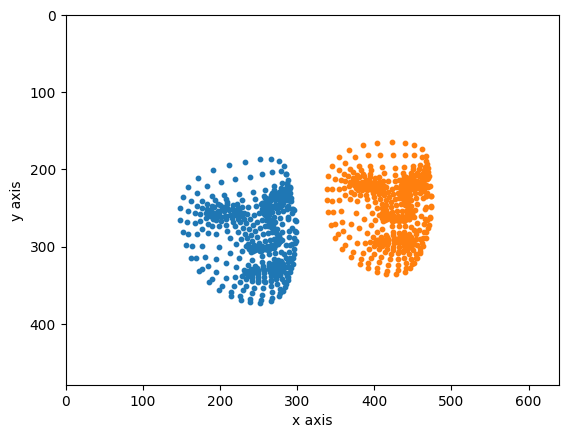

In [2]:
imgRef = torchvision.io.read_image(PathImg1)
imgTar = torchvision.io.read_image(PathImg2)

refKey = torch.tensor(np.load(PathNPY1), device=DEVICE)
tarKey = torch.tensor(np.load(PathNPY2), device=DEVICE)

height, width = imgRef.shape[1], imgRef.shape[2]
draw(width, height, refKey, tarKey, size=10, connect=False)

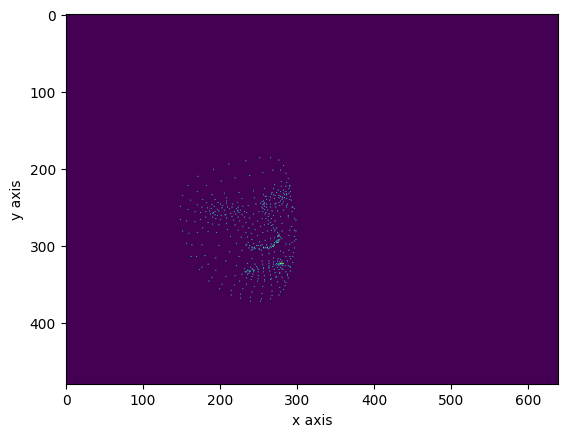

In [3]:
a = createMask(refKey, height, width)
showImageTensor(a, is3chan=False)

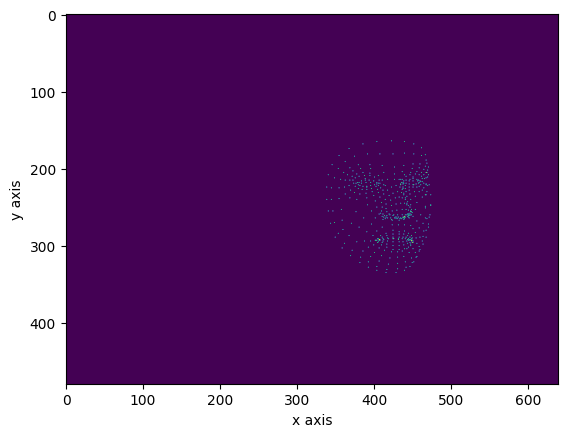

In [4]:
a = createMask(tarKey, height, width)
showImageTensor(a, is3chan=False)

## PlayGround

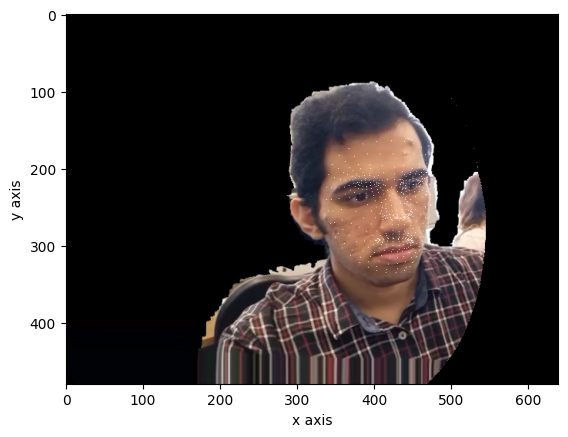

In [5]:
output = RenderImage(height, width, refKey, tarKey, imgRef, sd=0.01)

dummy = torch.squeeze(output)
dummy = createMask(tarKey, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
# showImageTensor(output.int(), is3chan=True, isOutput=True)
# showImageTensor(output, isOutput=True)

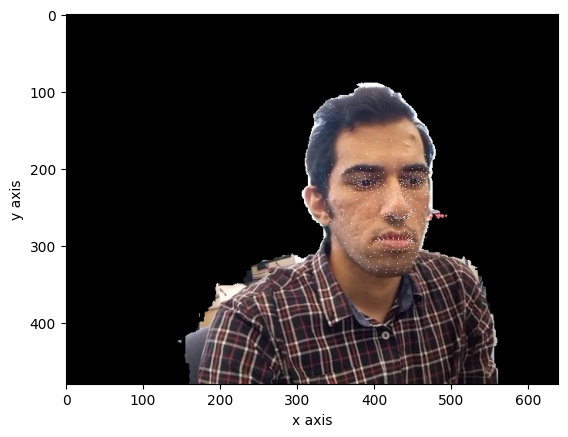

In [6]:
mm = createMask(tarKey, height, width, imgTar)
showImageTensor(mm, is3chan=True)

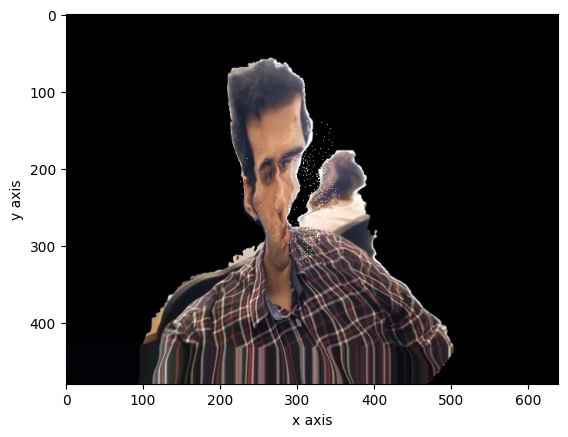

In [7]:
frameSize = (640, 480)

out = cv2.VideoWriter('idk.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 50
j = 50
k = 50
T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
# T = torch.tensor([0, 0, 0], device=DEVICE)

for j in range(50, 150):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(refKey, euler, T)
  output = RenderImage(height, width, refKey, newKeys, imgRef, sd=0.01, distMethod="gaussian")

  dummy = torch.squeeze(output)
  dummy = createMask(newKeys, height, width, dummy).int()
  
  img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
  img = np.moveaxis(np.uint8(img), 0, -1)
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


out.release()

In [8]:
refKey.dtype

torch.float64

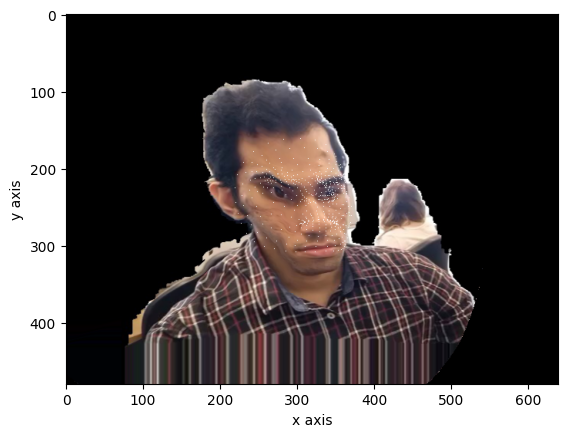

In [8]:
# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE) #+ torch.tensor([-0.3, 0.3, 0], device=DEVICE)
T = torch.tensor([0, 0, 0], device=DEVICE)

euler = torch.tensor([pi/4, 0, 0], device=DEVICE)
newKeys = TransformKeys(refKey, euler, T)
output = RenderImage(height, width, refKey, newKeys, imgRef)

dummy = torch.squeeze(output)
dummy = createMask(newKeys, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)


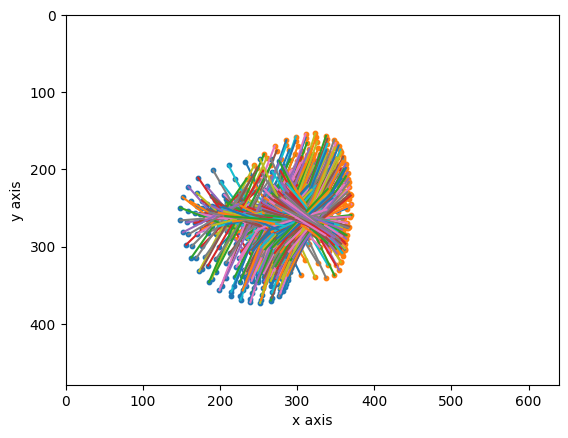

In [12]:
draw(width, height, refKey, newKeys, size=10, connect=True)

In [13]:
dkey = refKey - newKeys
sd = 0.01
flowX, flowY = dkey[:,0], dkey[:,1]
d1 = torch.linspace(0, 1, height, device=DEVICE)
d2 = torch.linspace(0, 1, width, device=DEVICE)

# meshx, meshy = torch.meshgrid(d1, d2, indexing='ij')
meshy, meshx = torch.meshgrid(d1, d2, indexing='ij')


MeshXE = meshx.expand(478, 480, 640)
MeshYE = meshy.expand(478, 480, 640)


MeshXE = MeshXE - refKey[:, 0].view(-1, 1, 1)
MeshYE = MeshYE - refKey[:, 1].view(-1, 1, 1)

MeshE = torch.exp(-(MeshXE * MeshXE + MeshYE * MeshYE) / (2 * sd * sd))
# MeshE = 1/(MeshXE * MeshXE + MeshYE * MeshYE + 1e-10)
WeightMeshX = MeshE * flowX.view(-1, 1, 1)
WeightMeshY = MeshE * flowY.view(-1, 1, 1)

InterpolatedFlowX = torch.sum(WeightMeshX, dim=0)/torch.sum(MeshE, dim=0)
InterpolatedFlowY = torch.sum(WeightMeshY, dim=0)/torch.sum(MeshE, dim=0)


In [7]:
d1 = torch.linspace(-1, 1, height)
d2 = torch.linspace(-1, 1, width)
meshx, meshy = torch.meshgrid(d1, d2, indexing='ij')
# meshx, meshy = meshx.to(DEVICE), meshy.to(DEVICE)

meshx_new = meshx.clone().detach().to(DEVICE)
meshy_new = meshy.clone().detach().to(DEVICE)

meshx_new = meshx_new + 2 * InterpolatedFlowY
meshy_new = meshy_new + 2 * InterpolatedFlowX

NameError: name 'InterpolatedFlowY' is not defined

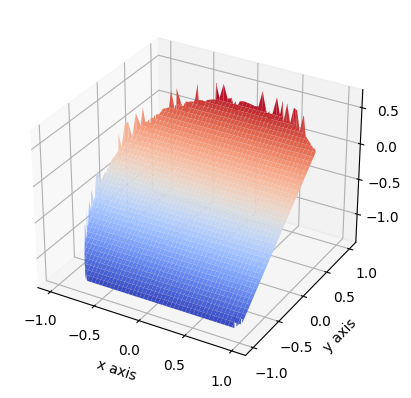

In [15]:
InterpolatedFlowX.shape

ax = plt.axes(projection='3d')
ax.plot_surface(meshx.cpu().numpy(), meshy.cpu().numpy(), meshy_new.cpu().numpy(), cmap=cm.coolwarm)
plt.xlabel("x axis")
plt.ylabel("y axis")
# ax.view_init(180, 180)
plt.show()

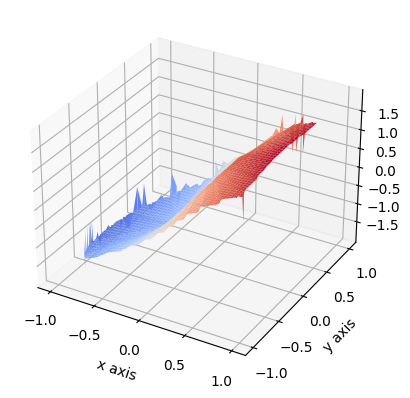

In [20]:


ax = plt.axes(projection='3d')
ax.plot_surface(meshx.cpu().numpy(), meshy.cpu().numpy(), meshx_new.cpu().numpy(), cmap=cm.coolwarm)
plt.xlabel("x axis")
plt.ylabel("y axis")
# ax.view_init(180, 180)
plt.show()

In [17]:
grid = torch.stack((meshy_new, meshx_new), 2)
img = imgRef.clone().detach().to(DEVICE)
grid = grid.unsqueeze(0)
#img = torch.tensor(img, dtype=torch.float, device=DEVICE)
img = img.float().to(DEVICE)
img = torch.unsqueeze(img, 0)
# grid = torch.tensor(grid, dtype=torch.float)
grid = grid.float()
output = torch.nn.functional.grid_sample(img, grid, padding_mode="border",align_corners=True)

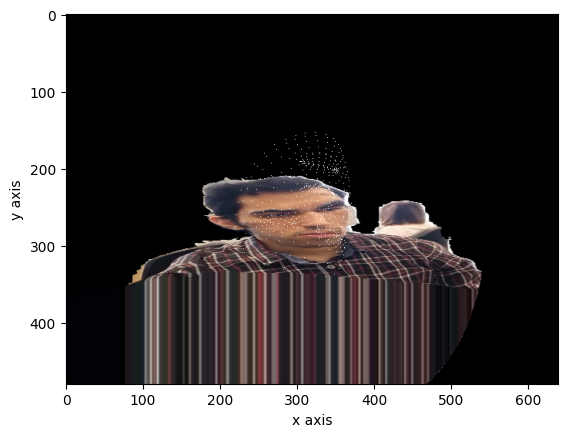

In [18]:
dummy = torch.squeeze(output)
dummy = createMask(newKeys, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)

## Mesh Playground


## Useless

In [9]:
frameSize = (640, 480)

out = cv2.VideoWriter('keypoints.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 50
j = 50
k = 50


# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
# for k in range(50, 250):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   newKeys = TransformKeys(refKey, euler, T)
#   output, mx, my = RenderImage(height, width, refKey, newKeys, imgRef)

#   dummy = torch.squeeze(output)
#   dummy = createMask(newKeys, height, width, dummy).int()
  
#   img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
#   img = np.moveaxis(np.uint8(img), 0, -1)
#   out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
T = torch.tensor([0, 0, 0], device=DEVICE)

for k in range(50, 52):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(refKey, euler, T)
  mask = createMask(refKey, height, width)
  mask = mask.repeat(3,1,1)
  output, mx, my = RenderImage(height, width, refKey, newKeys, mask)
  dummy = torch.squeeze(output)
  dummy = createMask(newKeys, height, width, dummy).int()
  
  # output = createMask(newKeys, height, width) * 255
  img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
  img = np.moveaxis(np.uint8(img), 0, -1)
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  # img = showImageTensor(output, is3chan=False, isOutput=False, returnOutput=True)
  # img = img.repeat(3,1,1)
  # out.write(np.moveaxis(np.uint8(img), 0, -1))

# for j in range(100):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   newKeys = TransformKeys(tarKey, euler, T)

#   output = createMask(newKeys, height, width) * 255


#   img = showImageTensor(output, is3chan=False, isOutput=False, returnOutput=True)
#   img = img.repeat(3,1,1)
#   out.write(np.moveaxis(np.uint8(img), 0, -1))


# for k in range(100):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   newKeys = TransformKeys(tarKey, euler, T)

#   output = createMask(newKeys, height, width) * 255


#   img = showImageTensor(output, is3chan=False, isOutput=False, returnOutput=True)
#   img = img.repeat(3,1,1)
#   out.write(np.moveaxis(np.uint8(img), 0, -1))

out.release()

ValueError: not enough values to unpack (expected 3, got 1)

In [10]:
# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
T = torch.tensor([0, 0, 0], device=DEVICE)

euler = torch.tensor([0, 0, pi], device=DEVICE)
newKeys = TransformKeys(refKey, euler, T)
mask = createMask(refKey, height, width)
mask = mask.repeat(3,1,1)
output, mx, my = RenderImage(height, width, refKey, newKeys, mask)
dummy = torch.squeeze(output)
# dummy = createMask(newKeys, height, width, dummy).int()

# output = createMask(newKeys, height, width) * 255
img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
img = np.moveaxis(np.uint8(img), 0, -1)
out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ValueError: not enough values to unpack (expected 3, got 1)